In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for selecting the text column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

# Custom transformer for applying business rules
class BusinessRulesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rules):
        self.rules = rules

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply business rules
        X_transformed = X.copy()
        for rule in self.rules:
            X_transformed = rule(X_transformed)
        # Return only the new features (business rules) as a DataFrame
        return X_transformed[['meowed_binary']]

# Example rule: binary feature if 'meowed' is present in text
def meowed_rule(X):
    X['meowed_binary'] = X['text'].apply(lambda x: 1 if 'meowed' in x else 0)
    return X

# Larger dummy dataset with more samples
df = pd.DataFrame({
    'text': [
        "The cat meowed loudly", "It was a quiet night", "Dogs bark",
        "The cat purred softly", "The dog growled", "The cat meowed again",
        "Silence in the night", "A distant bark was heard", "The cat meowed",
        "The dog barked loudly", "The cat purred", "Dogs are loyal",
        "Cats are independent", "The dog barked again", "Quiet meows in the night"
    ],
    'label': [0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0]
})

# Business rules
rules = [meowed_rule]

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Feature extraction using TF-IDF
tfidf = TfidfVectorizer()

# Base models for voting classifier
clf1 = LogisticRegression(random_state=42)
clf2 = RandomForestClassifier(random_state=42)
clf3 = GradientBoostingClassifier(random_state=42)
clf4 = SVC(probability=True, random_state=42)

# Voting Classifier (ensemble of models)
voting_clf = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('gb', clf3),
    ('svc', clf4)],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Create a pipeline for the model
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', TextSelector(key='text')),  # Select text column
            ('vectorizer', tfidf),
        ])),
        ('business_rules', BusinessRulesTransformer(rules=rules)),  # Apply business rules
    ])),
    ('classifier', voting_clf)  # Classification using the voting classifier
])

# Train the model using the training data
pipeline.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model's performance
# print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.3333333333333333


In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# Custom transformer for selecting the text column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

# Custom transformer for applying business rules
class BusinessRulesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rules):
        self.rules = rules

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply business rules
        X_transformed = X.copy()
        for rule in self.rules:
            X_transformed = rule(X_transformed)
        # Return only the new features (business rules) as a DataFrame
        return X_transformed[['meowed_binary']]

# Example rule: binary feature if 'meowed' is present in text
def meowed_rule(X):
    X['meowed_binary'] = X['text'].apply(lambda x: 1 if 'meowed' in x else 0)
    return X

# Dummy dataset
df = pd.DataFrame({
    'text': [
        "The cat meowed loudly", "It was a quiet night", "Dogs bark",
        "The cat purred softly", "The dog growled", "The cat meowed again",
        "Silence in the night", "A distant bark was heard", "The cat meowed",
        "The dog barked loudly", "The cat purred", "Dogs are loyal",
        "Cats are independent", "The dog barked again", "Quiet meows in the night"
    ],
    'label': [0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0]
})

# Business rules
rules = [meowed_rule]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Create a pipeline with text preprocessing and model training
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', TextSelector(key='text')),  # Select text column
            ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))),  # TF-IDF with basic preprocessing
        ])),
        ('business_rules', BusinessRulesTransformer(rules=rules)),  # Apply business rules
    ])),
    ('classifier', VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ], voting='soft'))  # Classification using the voting classifier
])

# Grid search parameters
param_grid = {
    'features__text__vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__lr__C': [0.1, 1, 10],
    'classifier__rf__n_estimators': [50, 100],
    'classifier__gb__n_estimators': [50, 100],
    'classifier__svc__C': [0.1, 1, 10]
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Predict the labels for the test data
y_pred = grid_search.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'classifier__gb__n_estimators': 50, 'classifier__lr__C': 0.1, 'classifier__rf__n_estimators': 50, 'classifier__svc__C': 0.1, 'features__text__vectorizer__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.67      0.50      0.56         3
weighted avg       1.00      0.67      0.78         3

Accuracy: 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for selecting the text column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

# Custom transformer for applying business rules
class BusinessRulesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rules):
        self.rules = rules

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply business rules
        X_transformed = X.copy()
        for rule in self.rules:
            X_transformed = rule(X_transformed)
        # Return only the new features (business rules) as a DataFrame
        return X_transformed[['meowed_binary']]

# Example rule: binary feature if 'meowed' is present in text
def meowed_rule(X):
    X['meowed_binary'] = X['text'].apply(lambda x: 1 if 'meowed' in x else 0)
    return X

# Dummy dataset
df = pd.DataFrame({
    'text': [
        "The cat meowed loudly", "It was a quiet night", "Dogs bark",
        "The cat purred softly", "The dog growled", "The cat meowed again",
        "Silence in the night", "A distant bark was heard", "The cat meowed",
        "The dog barked loudly", "The cat purred", "Dogs are loyal",
        "Cats are independent", "The dog barked again", "Quiet meows in the night"
    ],
    'label': [0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0]
})

# Business rules
rules = [meowed_rule]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Create a pipeline with text preprocessing and model training
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', TextSelector(key='text')),  # Select text column
            ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))),  # TF-IDF with basic preprocessing
        ])),
        ('business_rules', BusinessRulesTransformer(rules=rules)),  # Apply business rules
    ])),
    ('classifier', OneVsRestClassifier(VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ], voting='soft')))  # Classification using the voting classifier
])

# Grid search parameters
param_grid = {
    'features__text__vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__estimator__lr__C': [0.1, 1, 10],
    'classifier__estimator__rf__n_estimators': [50, 100],
    'classifier__estimator__gb__n_estimators': [50, 100],
    'classifier__estimator__svc__C': [0.1, 1, 10]
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Predict the labels for the test data
y_pred = grid_search.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found: {'classifier__estimator__gb__n_estimators': 50, 'classifier__estimator__lr__C': 1, 'classifier__estimator__rf__n_estimators': 50, 'classifier__estimator__svc__C': 1, 'features__text__vectorizer__ngram_range': (1, 1)}
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         0
           2       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.67      0.50      0.56         3
weighted avg       1.00      0.67      0.78         3

Accuracy: 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
!pip install imbalanced-learn


In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Custom transformer for selecting the text column
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

# Custom transformer for applying business rules
class BusinessRulesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rules):
        self.rules = rules

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Apply business rules
        X_transformed = X.copy()
        for rule in self.rules:
            X_transformed = rule(X_transformed)
        # Return only the new features (business rules) as a DataFrame
        return X_transformed[['meowed_binary']]

# Example rule: binary feature if 'meowed' is present in text
def meowed_rule(X):
    X['meowed_binary'] = X['text'].apply(lambda x: 1 if 'meowed' in x else 0)
    return X

# Dummy dataset
df = pd.DataFrame({
    'text': [
        "The cat meowed loudly", "It was a quiet night", "Dogs bark",
        "The cat purred softly", "The dog growled", "The cat meowed again",
        "Silence in the night", "A distant bark was heard", "The cat meowed",
        "The dog barked loudly", "The cat purred", "Dogs are loyal",
        "Cats are independent", "The dog barked again", "Quiet meows in the night"
    ],
    'label': [0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 0, 2, 0, 2, 0]
})

# Business rules
rules = [meowed_rule]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

# Create the pipeline with SMOTE and OneVsRestClassifier
pipeline = ImbPipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('selector', TextSelector(key='text')),  # Select text column
            ('vectorizer', TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))),  # TF-IDF with basic preprocessing
        ])),
        ('business_rules', BusinessRulesTransformer(rules=rules)),  # Apply business rules
    ])),
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE
    ('classifier', OneVsRestClassifier(VotingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ], voting='soft')))  # Classification using the voting classifier
])

# Grid search parameters
param_grid = {
    'features__text__vectorizer__ngram_range': [(1, 1), (1, 2)],
    'classifier__estimator__lr__C': [0.1, 1, 10],
    'classifier__estimator__rf__n_estimators': [50, 100],
    'classifier__estimator__gb__n_estimators': [50, 100],
    'classifier__estimator__svc__C': [0.1, 1, 10]
}

# Grid Search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", grid_search.best_params_)

# Predict the labels for the test data
y_pred = grid_search.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


ValueError: 
All the 360 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/usr/local/lib/python3.10/dist-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/usr/local/lib/python3.10/dist-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/base.py", line 112, in fit_resample
    output = self._fit_resample(X, y)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py", line 389, in _fit_resample
    nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 808, in kneighbors
    raise ValueError(
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 6

--------------------------------------------------------------------------------
216 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 329, in fit
    Xt, yt = self._fit(X, y, routed_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 265, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/usr/local/lib/python3.10/dist-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 1057, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
  File "/usr/local/lib/python3.10/dist-packages/imblearn/base.py", line 208, in fit_resample
    return super().fit_resample(X, y)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/base.py", line 112, in fit_resample
    output = self._fit_resample(X, y)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py", line 389, in _fit_resample
    nns = self.nn_k_.kneighbors(X_class, return_distance=False)[:, 1:]
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 808, in kneighbors
    raise ValueError(
ValueError: Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 6


In [22]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Dummy dataset
df = pd.DataFrame({
    'text': [
        "I love this movie", "This movie is terrible", "Great film!", "I didn't like it",
        "Absolutely fantastic!", "It was a waste of time", "Really enjoyed it",
        "Not worth watching", "One of the best movies", "Horrible experience"
    ],
    'label': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]  # 1: Positive, 0: Negative
})

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 4
LEARNING_RATE = 2e-5

# Initialize the tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the pre-trained BERT model and add a classification head
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_train_loss}')

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, predictions))
print("Accuracy:", accuracy_score(true_labels, predictions))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 0.9486088156700134
Epoch 2, Loss: 0.7135700583457947
Epoch 3, Loss: 0.6251068115234375
Epoch 4, Loss: 0.5541852712631226
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2

Accuracy: 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Example multi-class dataset
df = pd.DataFrame({
    'text': [
        "I love this movie", "This movie is terrible", "Great film!", "I didn't like it",
        "Absolutely fantastic!", "It was a waste of time", "Really enjoyed it",
        "Not worth watching", "One of the best movies", "Horrible experience",
        "Mediocre film", "Outstanding!", "Could be better", "Not so good", "Highly recommended"
    ],
    'label': [1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2]  # Example labels: 0: Negative, 1: Neutral, 2: Positive
})

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 4
LEARNING_RATE = 2e-5

# Initialize the tokenizer and datasets
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the pre-trained XLNet model and add a classification head
num_labels = 3  # Set this to the number of classes in your dataset
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=num_labels)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_train_loss}')

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, predictions, labels=list(range(num_labels))))
print("Accuracy:", accuracy_score(true_labels, predictions))


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 1.0475382208824158
Epoch 2, Loss: 0.9312527179718018
Epoch 3, Loss: 0.9517163336277008
Epoch 4, Loss: 1.0435830354690552
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1
           2       1.00      1.00      1.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3

Accuracy: 0.6666666666666666


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Example multi-class dataset
df = pd.DataFrame({
    'text': [
        "I love this movie", "This movie is terrible", "Great film!", "I didn't like it",
        "Absolutely fantastic!", "It was a waste of time", "Really enjoyed it",
        "Not worth watching", "One of the best movies", "Horrible experience",
        "Mediocre film", "Outstanding!", "Could be better", "Not so good", "Highly recommended"
    ],
    'label': [1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2]  # Example labels: 0: Negative, 1: Neutral, 2: Positive
})

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 4
LEARNING_RATE = 2e-5

# Initialize the tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LEN)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load the pre-trained BERT model and add a classification head
num_labels = 3  # Set this to the number of classes in your dataset
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Training Loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_train_loss}')

# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Classification Report:")
print(classification_report(true_labels, predictions, labels=list(range(num_labels))))
print("Accuracy:", accuracy_score(true_labels, predictions))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Loss: 1.103592336177826
Epoch 2, Loss: 1.0454453825950623
Epoch 3, Loss: 1.0725820660591125
Epoch 4, Loss: 1.0146558284759521
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.11      0.33      0.17         3
weighted avg       0.11      0.33      0.17         3

Accuracy: 0.3333333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import optuna

# Example multi-class dataset
df = pd.DataFrame({
    'text': [
        "I love this movie", "This movie is terrible", "Great film!", "I didn't like it",
        "Absolutely fantastic!", "It was a waste of time", "Really enjoyed it",
        "Not worth watching", "One of the best movies", "Horrible experience",
        "Mediocre film", "Outstanding!", "Could be better", "Not so good", "Highly recommended"
    ],
    'label': [1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 2]  # Example labels: 0: Negative, 1: Neutral, 2: Positive
})

# Split data into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Define a custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_epochs', 2, 6)
    max_len = trial.suggest_int('max_len', 64, 256)

    # Initialize the tokenizer and datasets
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len)
    test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load the pre-trained BERT model and add a classification head
    num_labels = 3  # Number of classes
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

    # Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * num_epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Training Loop
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

    # Evaluation
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

# Optuna Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

# Train and evaluate the final model with the best parameters
best_params = study.best_params
print(f"Using best parameters: {best_params}")

# Retrain the model with best hyperparameters
learning_rate = best_params['learning_rate']
batch_size = best_params['batch_size']
num_epochs = best_params['num_epochs']
max_len = best_params['max_len']

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

avg_train_loss = total_loss / len(train_loader)
print(f'Final Model Training Loss: {avg_train_loss}')

# Final Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Final Classification Report:")
print(classification_report(true_labels, predictions, labels=list(range(num_labels))))
print("Final Accuracy:", accuracy_score(true_labels, predictions))


In [ ]:
import boto3
from transformers import LayoutLMv3Tokenizer, LayoutLMv3ForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
import torch

# AWS Textract client setup
textract_client = boto3.client('textract')

def extract_text_and_layout_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as document:
        response = textract_client.analyze_document(
            Document={'Bytes': document},
            FeatureTypes=['TABLES', 'FORMS']
        )

    texts = []
    bbox_list = []

    for item in response['Blocks']:
        if item['BlockType'] == 'LINE':
            text = item['Text']
            bbox = item['Geometry']['BoundingBox']
            bbox_list.append([
                bbox['Left'], bbox['Top'],
                bbox['Width'], bbox['Height']
            ])
            texts.append(text)

    return texts, bbox_list

# Tokenizer and model initialization
tokenizer = LayoutLMv3Tokenizer.from_pretrained('microsoft/layoutlmv3-base')
model = LayoutLMv3ForSequenceClassification.from_pretrained('microsoft/layoutlmv3-base', num_labels=3)

def prepare_data(texts, bbox_list, max_len):
    encoding = tokenizer(
        texts,
        boxes=bbox_list,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='pt'
    )
    return encoding

# Define a custom Dataset class
class PDFDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Prepare data for training
def prepare_dataset_for_training(pdf_paths, labels, max_len):
    all_texts = []
    all_bbox_list = []
    for pdf_path in pdf_paths:
        texts, bbox_list = extract_text_and_layout_from_pdf(pdf_path)
        all_texts.extend(texts)
        all_bbox_list.extend(bbox_list)

    encodings = prepare_data(all_texts, all_bbox_list, max_len)
    return PDFDataset(encodings, labels)

# Example multi-page PDFs and corresponding labels
pdf_paths = ['your_multi_page_pdf1.pdf', 'your_multi_page_pdf2.pdf']
labels = [0, 1]  # Adjust according to your multi-class problem

# Create dataset and dataloader
max_len = 512
dataset = prepare_dataset_for_training(pdf_paths, labels, max_len)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    evaluation_strategy='epoch'
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset
)

# Training the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(results)

# Prediction function for new multi-page PDFs
def predict(pdf_path):
    texts, bbox_list = extract_text_and_layout_from_pdf(pdf_path)
    encoded_data = prepare_data(texts, bbox_list, max_len)
    inputs = {key: torch.tensor(val).unsqueeze(0) for key, val in encoded_data.items()}  # Add batch dimension
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions

# Example prediction
pdf_to_classify = 'new_multi_page_pdf.pdf'
predicted_class = predict(pdf_to_classify)
print(predicted_class)


In [ ]:
https://github.com/ahmedrasheed3995/DocumentClassification

In [ ]:
https://www.mlexpert.io/blog/document-classification-with-layoutlmv3

In [ ]:
import pandas as pd

def find_table_headers(df, threshold=0.5):
    """
    Identify potential header rows in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - threshold: ratio of non-numeric cells to consider a row as header

    Returns:
    - List of indices of rows that are considered as potential headers
    """
    potential_headers = []

    for idx, row in df.iterrows():
        # Count non-numeric cells in the row
        non_numeric_count = sum(pd.notnull(row) & row.apply(lambda x: isinstance(x, str)))
        total_count = len(row)

        # Ratio of non-numeric cells to total cells
        non_numeric_ratio = non_numeric_count / total_count

        # Check if the ratio exceeds the threshold
        if non_numeric_ratio > threshold:
            potential_headers.append(idx)

    return potential_headers

# Load Excel file
df = pd.read_excel('your_excel_file.xlsx', sheet_name='Sheet1')

# Identify potential header rows
header_indices = find_table_headers(df)
print("Potential header rows:", header_indices)

# Optionally, you can extract and inspect these rows
for idx in header_indices:
    print(f"Header candidate (row {idx}):")
    print(df.iloc[idx])


In [26]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load a sample dataset
data = load_iris()
X = data.data
y = data.target
class_names = data.target_names

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate the classification report
report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Display the F1 score for each class
print("F1 Score for each class:")
for class_name in class_names:
    f1 = report[class_name]['f1-score']
    print(f"{class_name}: {f1:.4f}")

# Alternatively, calculate F1 score manually
f1_scores = f1_score(y_test, y_pred, average=None)
print("\nF1 Score for each class (manual calculation):")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {f1_scores[i]:.4f}")


F1 Score for each class:
setosa: 1.0000
versicolor: 1.0000
virginica: 1.0000

F1 Score for each class (manual calculation):
setosa: 1.0000
versicolor: 1.0000
virginica: 1.0000


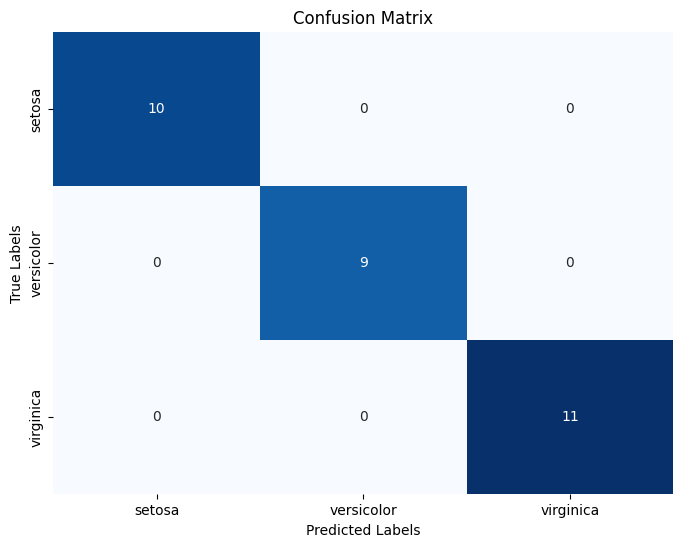

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

# Load a sample dataset
data = load_iris()
X = data.data
y = data.target
class_names = data.target_names

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


In [ ]:
The ideal sample size for creating a text classification model with 7 classes depends on several factors, including the complexity of the problem, the quality of the data, the amount of variability in the text, and the performance goals. However, here are some general guidelines and considerations to help determine an appropriate sample size:

General Guidelines
Rule of Thumb:
Minimum Sample Size: A common rule of thumb is to have at least 10-20 examples per class for a basic model. For 7 classes, this would translate to at least 70-140 samples.
More Samples for Better Performance: For better performance and generalization, especially with more complex models, having 100-500 samples per class is often recommended. This translates to a total of 700-3500 samples for 7 classes.
Complexity of the Task:
Simple Tasks: For tasks with straightforward classification (e.g., distinguishing between 7 clearly different classes with distinct characteristics), fewer samples might be sufficient.
Complex Tasks: For tasks requiring nuanced understanding (e.g., sentiment analysis or topics with subtle differences), more samples are generally needed.
Data Quality:
High-Quality Data: If your data is clean, well-labeled, and representative, you might get good performance with fewer samples.
Noisy Data: If your data is noisy or less representative, you may need more samples to train a robust model.
Model Complexity:
Simple Models: For simpler models (e.g., Naive Bayes), you might need fewer samples compared to more complex models (e.g., deep learning models).
Deep Learning Models: For models like BERT or other transformers, you generally need more data to achieve good performance due to their high capacity and complexity.
Cross-Validation:
Use cross-validation to ensure that your sample size is sufficient and that your model generalizes well. With more data, cross-validation results tend to be more reliable.
Data Augmentation:
If collecting more data is challenging, consider data augmentation techniques (e.g., paraphrasing, adding noise) to artificially increase the size of your dataset.
Example Calculation
For a text classification task with 7 classes, aiming for a robust model might look like this:

Basic Model: Minimum 10-20 samples per class → 70-140 samples total.
Moderate Model: 50-100 samples per class → 350-700 samples total.
Advanced Model: 100-500 samples per class → 700-3500 samples total.
Summary
Minimum: 70-140 samples for a basic model.
Moderate: 350-700 samples for better performance.
Advanced: 700-3500 samples for high-quality models and deep learning.
If you're working with a highly complex problem or using advanced models, aim for the higher end of the range. Ensure that your sample size is sufficient to capture the variability in your text data and to train a model that generalizes well.

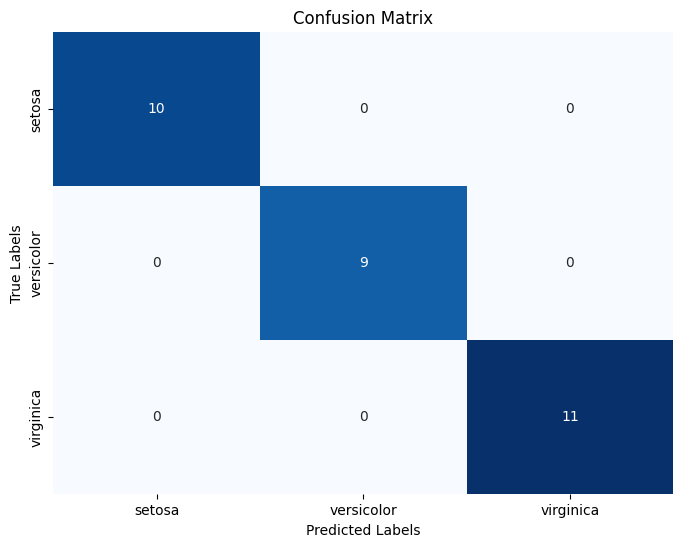

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.utils.class_weight import compute_class_weight

# Load a sample dataset
data = load_iris()
X = data.data
y = data.target
class_names = data.target_names

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classifier with class weights
clf = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


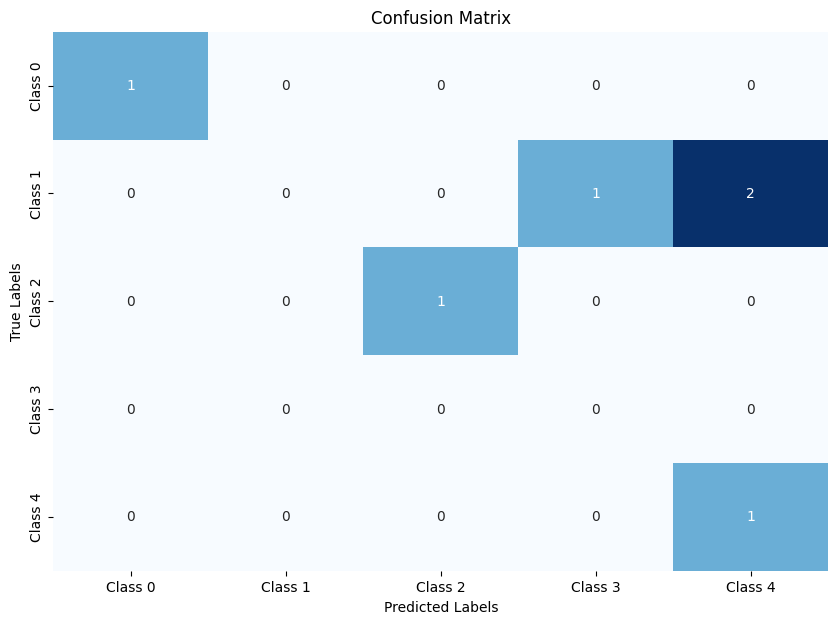

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         1
     Class 1       0.00      0.00      0.00         3
     Class 2       1.00      1.00      1.00         1
     Class 3       0.00      0.00      0.00         0
     Class 4       0.33      1.00      0.50         1

    accuracy                           0.50         6
   macro avg       0.47      0.60      0.50         6
weighted avg       0.39      0.50      0.42         6



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Sample data with 7 classes (4 distinct and 3 similar)
data = pd.DataFrame({
    'text': [
        "The cat meowed loudly",
        "Dogs bark loudly",
        "The cat slept peacefully",
        "The dog slept quietly",
        "The cat meowed softly",
        "Dogs bark softly",
        "The cat was very active",
        "The dog was very active",
        "The cat was calm",
        "The dog was calm",
        "The dog ran fast",
        "The cat ran fast",
        "Dogs run slowly",
        "Cats run slowly",
        "The cat meowed again",
        "The dog barked again",
        "The cat played with a toy",
        "The dog played with a ball"
    ],
    'label': [
        0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6
    ]
})

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(data['label']), y=data['label'])
class_weight_dict = dict(zip(np.unique(data['label']), class_weights))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.3, random_state=42)

# Define TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Base models
clf1 = LogisticRegression(class_weight=class_weight_dict, random_state=42)
clf2 = RandomForestClassifier(class_weight=class_weight_dict, random_state=42)
clf3 = GradientBoostingClassifier(random_state=42)
clf4 = SVC(probability=True, class_weight=class_weight_dict, random_state=42)

# Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', clf1),
    ('rf', clf2),
    ('gb', clf3),
    ('svc', clf4)],
    voting='soft'  # Use 'soft' voting to take class probabilities into account
)

# Create a pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', voting_clf)
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Generate class names based on unique labels in y_test and y_pred
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
class_names = [f'Class {label}' for label in unique_labels]

# Create a DataFrame for better readability
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

# Sample Data
data = pd.DataFrame({
    'text': [
        "The cat meowed loudly",
        "Dogs bark loudly",
        "The cat slept peacefully",
        "The dog slept quietly",
        "The cat meowed softly",
        "Dogs bark softly",
        "The cat was very active",
        "The dog was very active",
        "The cat was calm",
        "The dog was calm",
        "The dog ran fast",
        "The cat ran fast",
        "Dogs run slowly",
        "Cats run slowly",
        "The cat meowed again",
        "The dog barked again",
        "The cat played with a toy",
        "The dog played with a ball"
    ],
    'label': [
        0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6
    ]
})

# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.3, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Mean pooling
    return embeddings

# Custom Transformer for BERT Embeddings
class BertTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return get_bert_embeddings(X)

# Custom Feature Union for combining TF-IDF and BERT
class CombinedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=1000)
        self.bert_transformer = BertTransformer()
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit TF-IDF
        X_tfidf = self.tfidf.fit_transform(X)

        # Fit BERT
        X_bert = self.bert_transformer.fit_transform(X)
        self.scaler.fit(X_bert)
        return self

    def transform(self, X):
        X_tfidf = self.tfidf.transform(X)
        X_bert = self.bert_transformer.transform(X)
        X_bert_scaled = self.scaler.transform(X_bert)
        return np.hstack([X_tfidf.toarray(), X_bert_scaled])

# Create Pipeline
pipeline = Pipeline(steps=[
    ('features', CombinedFeatures()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and Evaluate
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         1

    accuracy                           0.17         6
   macro avg       0.07      0.20      0.10         6
weighted avg       0.06      0.17      0.08         6

Confusion Matrix:
[[1 0 0 0 0]
 [1 0 0 0 2]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 1 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [36]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

# Sample Data
data = pd.DataFrame({
    'text': [
        "The cat meowed loudly",
        "Dogs bark loudly",
        "The cat slept peacefully",
        "The dog slept quietly",
        "The cat meowed softly",
        "Dogs bark softly",
        "The cat was very active",
        "The dog was very active",
        "The cat was calm",
        "The dog was calm",
        "The dog ran fast",
        "The cat ran fast",
        "Dogs run slowly",
        "Cats run slowly",
        "The cat meowed again",
        "The dog barked again",
        "The cat played with a toy",
        "The dog played with a ball"
    ],
    'label': [
        0, 1, 0, 1, 0, 1, 0, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6
    ]
})

# Business Rule Example: Binary feature if 'meowed' is present in text
class BusinessRulesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rules):
        self.rules = rules

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for rule in self.rules:
            X_transformed = rule(X_transformed)
        return X_transformed

# Example rule: binary feature if 'meowed' is present in text
def meowed_rule(X):
    X['meowed_binary'] = X['text'].apply(lambda x: 1 if 'meowed' in x else 0)
    return X

# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.3, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# BERT Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    inputs = tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()  # Mean pooling
    return embeddings

# Custom Transformer for BERT Embeddings
class BertTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return get_bert_embeddings(X)

# Custom Feature Union for combining TF-IDF, BERT, and Business Rules
class CombinedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, business_rules):
        self.tfidf = TfidfVectorizer(max_features=1000)
        self.bert_transformer = BertTransformer()
        self.scaler = StandardScaler()
        self.business_rules_transformer = BusinessRulesTransformer(rules=business_rules)

    def fit(self, X, y=None):
        X_transformed = self.business_rules_transformer.fit_transform(X)
        X_tfidf = self.tfidf.fit_transform(X_transformed['text'])
        X_bert = self.bert_transformer.fit_transform(X_transformed['text'])
        self.scaler.fit(X_bert)
        return self

    def transform(self, X):
        X_transformed = self.business_rules_transformer.transform(X)
        X_tfidf = self.tfidf.transform(X_transformed['text'])
        X_bert = self.bert_transformer.transform(X_transformed['text'])
        X_bert_scaled = self.scaler.transform(X_bert)
        return np.hstack([X_tfidf.toarray(), X_bert_scaled, X_transformed[['meowed_binary']].values])

# Create Pipeline
pipeline = Pipeline(steps=[
    ('features', CombinedFeatures(business_rules=[meowed_rule])),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and Evaluate
y_pred = pipeline.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         1
           5       0.00      0.00      0.00         0

    accuracy                           0.33         6
   macro avg       0.17      0.40      0.23         6
weighted avg       0.14      0.33      0.19         6

Confusion Matrix:
[[1 0 0 0 0]
 [1 0 0 1 1]
 [1 0 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.